# Explore timeseries patterns in cluster groups

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from src.data import qloader
from quilt.data.elijahc import ripc

from sklearn.manifold import TSNE

import bokeh.plotting as bp
from bokeh.models import ColumnDataSource, Span

## Load plasma mass spec data and join with necessary columns in samples and subjects tables

In [2]:
# Load sample and subject tables
samples = ripc.meta.samples()
subjects = ripc.meta.subjects()

#Load fold change dataset and merge categorical info from samples and subjects
plasma_log2fc = ripc.untargeted.log2fc_plasma()
fc_untargeted = pd.melt(plasma_log2fc, id_vars=['Molecular_Weight'], value_name='log2fc', var_name='sample_id')
fc_untargeted = fc_untargeted.join(samples.query("type == 'Plasma'").set_index('sample_id'), on='sample_id',how='left').dropna()
fc_untargeted.Subject = fc_untargeted.Subject.astype(int)
fc_untargeted['min'] = fc_untargeted['min'].astype(int)
# abs_fc = abs_fc.join(subjects.set_index('Subject'), on='Subject')


# abs_q = pd.melt(ripc.targeted.abs_quant(), id_vars=['Sample ID','Sample type'], value_name='value', var_name='Name')
# abs_q['sample_id'] = abs_q['Sample ID']
# abs_q = abs_q.join(samples[['sample_id','Subject','min','type']].set_index('sample_id'),on='sample_id').query("type == 'Plasma'")
# abs_q = abs_q.join(subjects.set_index('Subject'), on='Subject')

In [3]:
fc_untargeted = fc_untargeted.join(subjects.set_index('Subject'), on='Subject')
fc_untargeted.head()

,Molecular_Weight,sample_id,log2fc,Subject,type,timepoint,min,Sex,Height (m),Weight (kg)
0,65.01201,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
1,65.01261,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
2,65.01296,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
3,65.98965,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296
4,65.99026,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296


In [14]:
clust_df = ripc.cluster_segments.isomap_early_0_01_clusters()
clust_df.groupby('cluster_id').count()

,Molecular_Weight,dim_1,dim_2
cluster_id,,,
0,3,3,3
1,13,13,13
2,9,9,9
3,2241,2241,2241


In [5]:
subset = fc_untargeted.Molecular_Weight.isin(clust_df.Molecular_Weight.values)

In [6]:
fc_subset = fc_untargeted[subset].join(clust_df.set_index('Molecular_Weight'),on='Molecular_Weight')
fc_subset.head()

,Molecular_Weight,sample_id,log2fc,Subject,type,timepoint,min,Sex,Height (m),Weight (kg),dim_1,dim_2,cluster_id
78,67.98743,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,-0.534382,-0.023978,3
111,68.06219,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,-0.596401,-0.198148,3
116,68.06391,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,-4.021327,1.232482,1
185,69.06730,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,-2.878273,0.712278,1
257,70.04333,10A,0.0,10,Plasma,A,0,Male,1.96,85.275296,1.044464,-0.020643,3


In [15]:
fc_subset[['Molecular_Weight','cluster_id']].drop_duplicates().groupby('cluster_id').count()

,Molecular_Weight
cluster_id,
1,7
2,2
3,522


In [8]:
samples.head(2)

,sample_id,Subject,type,timepoint,min
0,1A,1,Plasma,A,0
1,1B,1,Plasma,B,2


In [10]:
sns.set_context('talk')
def plot_by_cluster(df,title=None,legend='brief'):
    groups = df.cluster_id.drop_duplicates().values
    num_groups = len(groups)
    fig,axs = plt.subplots(num_groups,1,figsize=(8,10),sharex=True)
    for ax,clust_id in zip(axs,groups):
        
        sns.lineplot(x='min',y='log2fc',hue='Sex',data=df.query('cluster_id == {}'.format(clust_id)),
                    ax=ax,legend=legend,)
        ax.set_ylabel('Group {}: '.format(clust_id)+r'$\log_{2}(FC)$')
    
    
#     axs[1].set_ylabel('Amount'+r' ($\mu$mol)')
    
    if title is not None:
        axs[0].set_title(title)
#         axs[1].set_title(title+r' ($\mu$mol)')
    axs[2].set_xlabel('Time (min)')
    fig.tight_layout()
    return fig

## Split absolute and foldchange datasets by sex and plot some of the metabolites

/home/elijahc/.pyenv/versions/jupyterlab-gpu/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


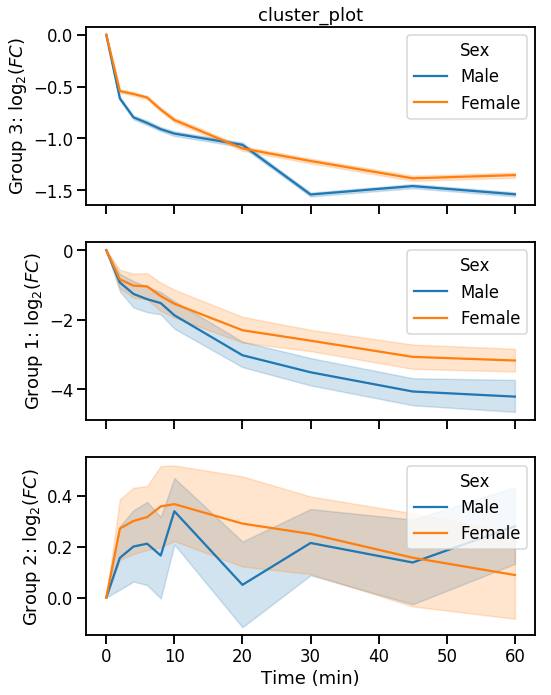

In [11]:
fig = plot_by_cluster(fc_subset,title='cluster_plot')
fig.savefig('../viz/cluster_groups/isomap_early_0.01.png',dpi=300)

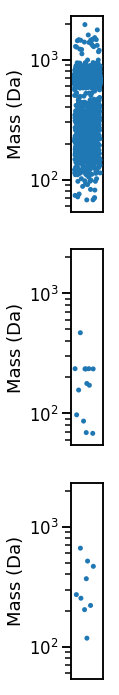

In [17]:
groups = fc_subset.cluster_id.drop_duplicates().values
num_groups = len(groups)
fig,axs = plt.subplots(num_groups,1,figsize=(2,10),sharey=True)

for clust_id,ax in zip(groups,axs):

    g = sns.stripplot(x='cluster_id',y='Molecular_Weight',data=clust_df.query('cluster_id == {}'.format(clust_id)),
                      jitter=0.4,ax=ax)
    # g.axes.yaxis.set_minor_locator(tkr.LogLocator(base=10, subs='all'))
    # g.axes.yaxis.set_minor_formatter(tkr.NullFormatter())
    g.axes.set_yscale('log')
    ax.set_xlabel('')
    ax.set_ylabel('Mass (Da)')
    ax.set_xticks([])
    

fig.tight_layout()
fig.savefig('../viz/cluster_groups/mass_by_group.png',dpi=300)

# g.ax.grid(True,which="both",ls="--",c='gray')

In [13]:
fig = pairplots('Kynurenine',title='Kynurenine')
fig.savefig('../viz/mvf_timeseries/kynurenine.png',dpi=300)

NameError: name 'pairplots' is not defined

In [ ]:
# metab = 'Succinate'
fig = pairplots('Succinate','Succinate')

fig.savefig('../viz/mvf_timeseries/succinate.png',dpi=300)

In [ ]:
fig = pairplots('L-Glutamate','Glutamate')
fig.savefig('../viz/mvf_timeseries/glutamate.png',dpi=300)

In [ ]:
fig = pairplots('Tryptophan',title='Tryptophan')
fig.savefig('../viz/mvf_timeseries/tryptophan.png',dpi=300)